# LangGraphで作るAIエージェント実践入門

## 9.3 ハンズオン：Q&Aアプリケーション

In [44]:
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22
!pip install langchain==0.3.0 langchain_google_genai==2.0.9 langgraph==0.2.22

In [45]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [46]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

In [47]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(
        default="", description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="回答履歴"
    )
    current_judge: bool = Field(
        default=False, description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="", description="品質チェックの判定理由"
    )

In [48]:
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import ConfigurableField

# llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0.0) # 変更後

# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
# llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))
llm = llm.configurable_fields(max_output_tokens=ConfigurableField(id='max_output_tokens'))

In [49]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
"""質問を分析し、最も適切な回答担当ロールを選択してください。

選択肢:
{role_options}

回答は選択肢の番号（1、2、または3）のみを返してください。

質問: {query}
""".strip()
    )
    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    # chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    chain = prompt | llm.with_config(configurable=dict(max_output_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}

In [50]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
"""あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

In [51]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="判定結果")
    reason: str = Field(default="", description="判定理由")

def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
"""以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
また、その判断理由も説明してください。

ユーザーからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
    }

In [52]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

In [53]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

In [54]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

In [55]:
# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

In [56]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

In [57]:
compiled = workflow.compile()

In [58]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

In [59]:
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AIとは、テキスト、画像、音声、コードなど、様々な種類の新しいコンテンツを作成できる人工知能の一種です。  既存のデータから学習し、そのパターンに基づいて似たような、しかし全く新しいアウトプットを生成します。  まるで人間が創造的に何かを生み出すように、AIがコンテンツを「生成」するというのが「生成AI」と呼ばれる所以です。\n\n以下、生成AIの主要な側面を詳しく説明します。\n\n**1. 基盤技術:**\n\n* **機械学習:** 生成AIの中核技術は機械学習、特に深層学習です。  大量のデータを使ってモデルを訓練し、データ内のパターンや関係性を学習させます。\n* **ニューラルネットワーク:** 深層学習では、人間の脳の神経細胞ネットワークを模倣したニューラルネットワークが用いられます。  特に、生成AIでは、GAN（敵対的生成ネットワーク）、Transformer、VAE（変分オートエンコーダ）などのアーキテクチャが重要な役割を果たします。\n\n**2. 生成AIの種類と用途:**\n\n* **テキスト生成:**  文章作成、翻訳、要約、チャットボット、コード生成など。 例：GPT-3、Bard、Jasper\n* **画像生成:** 写真、イラスト、絵画、3Dモデルなどの作成、画像の変換や編集。 例：DALL-E 2、Midjourney、Stable Diffusion\n* **音声生成:**  音声合成、音楽生成、音声変換など。 例：WaveNet、MuseNet\n* **動画生成:**  短い動画クリップの作成、動画編集、動画の変換など。 Runway ML, Synthesia など。\n* **コード生成:**  特定のタスクを実行するコードの自動生成。 GitHub Copilot, Tabnine など。\n\n**3. 生成AIのメリット:**\n\n* **効率性向上:**  これまで人間が行っていた作業を自動化し、時間とコストを削減。\n* **創造性の拡張:**  新しいアイデアやコンテンツの創造を支援し、人間の創造性を拡張。\n* **パーソナライズ化:**  個

In [60]:
print(result["messages"][-1])

生成AIとは、テキスト、画像、音声、コードなど、様々な種類の新しいコンテンツを作成できる人工知能の一種です。  既存のデータから学習し、そのパターンに基づいて似たような、しかし全く新しいアウトプットを生成します。  まるで人間が創造的に何かを生み出すように、AIがコンテンツを「生成」するというのが「生成AI」と呼ばれる所以です。

以下、生成AIの主要な側面を詳しく説明します。

**1. 基盤技術:**

* **機械学習:** 生成AIの中核技術は機械学習、特に深層学習です。  大量のデータを使ってモデルを訓練し、データ内のパターンや関係性を学習させます。
* **ニューラルネットワーク:** 深層学習では、人間の脳の神経細胞ネットワークを模倣したニューラルネットワークが用いられます。  特に、生成AIでは、GAN（敵対的生成ネットワーク）、Transformer、VAE（変分オートエンコーダ）などのアーキテクチャが重要な役割を果たします。

**2. 生成AIの種類と用途:**

* **テキスト生成:**  文章作成、翻訳、要約、チャットボット、コード生成など。 例：GPT-3、Bard、Jasper
* **画像生成:** 写真、イラスト、絵画、3Dモデルなどの作成、画像の変換や編集。 例：DALL-E 2、Midjourney、Stable Diffusion
* **音声生成:**  音声合成、音楽生成、音声変換など。 例：WaveNet、MuseNet
* **動画生成:**  短い動画クリップの作成、動画編集、動画の変換など。 Runway ML, Synthesia など。
* **コード生成:**  特定のタスクを実行するコードの自動生成。 GitHub Copilot, Tabnine など。

**3. 生成AIのメリット:**

* **効率性向上:**  これまで人間が行っていた作業を自動化し、時間とコストを削減。
* **創造性の拡張:**  新しいアイデアやコンテンツの創造を支援し、人間の創造性を拡張。
* **パーソナライズ化:**  個々のニーズに合わせたコンテンツやサービスの提供。
* **アクセシビリティ向上:**  高度なスキルや専門知識を持たない人でも、簡単にコンテンツを作成できる。

**4. 生成AIの課題:**



In [65]:
initial_state = State(query="生成AIについて教えてください")
result = await compiled.ainvoke(initial_state)
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AIは、テキスト、画像、音声、コードなど、様々な種類のコンテンツを生成できる人工知能の一種です。人間が作成した大量のデータでトレーニングされ、学習したパターンに基づいて新しい、オリジナルのアウトプットを作成します。  これは、単に既存のデータを再構成するのではなく、新しいものを創造するという点で、従来のAIとは一線を画しています。\n\n以下に、生成AIの主要な側面を詳しく説明します。\n\n**1. 基礎技術:**\n\n* **機械学習:** 生成AIの中核技術は機械学習、特に深層学習（ディープラーニング）です。  ニューラルネットワークと呼ばれる複雑なアルゴリズムを使用して、データからパターンを学習し、その知識を新しいコンテンツの生成に応用します。\n* **大規模言語モデル (LLM):** テキストベースの生成AIの中核を成すのがLLMです。膨大なテキストデータでトレーニングされ、人間のようなテキストを生成、翻訳、要約、質問応答などを行うことができます。  例としては、GPT-3、BERT、LaMDAなどが挙げられます。\n* **拡散モデル:** 画像生成AIでよく用いられる技術。ノイズから画像を生成するプロセスを学習することで、高品質で多様な画像を生成できます。Stable Diffusion、DALL-E 2などが代表例です。\n* **GAN (敵対的生成ネットワーク):**  2つのニューラルネットワーク（生成器と識別器）を競わせることで、よりリアルなデータ生成を目指す技術。画像生成、音声生成などに応用されています。\n\n**2. 生成AIの活用例:**\n\n* **テキスト生成:** 記事作成、小説執筆、詩作、スクリプト作成、翻訳、要約など。\n* **画像生成:** 写真、イラスト、デザイン、ロゴ作成など。\n* **音声生成:** 音楽作曲、音声合成、ナレーション作成など。\n* **コード生成:** プログラムコードの自動生成、バグ修正の支援など。\n* **ビデオ生成:** 短編動画、アニメーション作成など。\n* **3Dモデル生成:** ゲーム、建築、医療など様々な分野で利

In [62]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 49 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,670 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

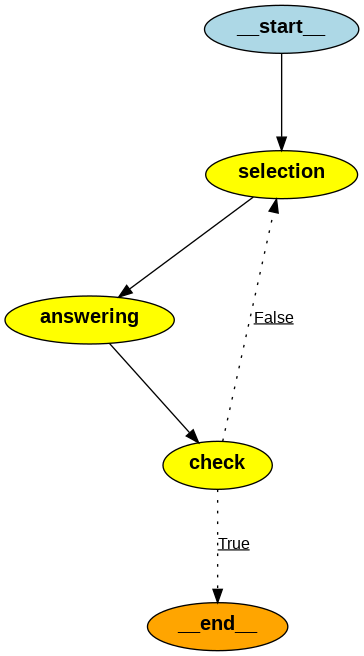

In [63]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

## 9.4 チェックポイント機能：ステートの永続化と再会

In [66]:
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 langgraph-checkpoint==1.0.11
!pip install langchain==0.3.0 langchain_google_genai==2.0.9 langgraph==0.2.22 langgraph-checkpoint==1.0.11

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 1.0.12
    Uninstalling langgraph-checkpoint-1.0.12:
      Successfully uninstalled langgraph-checkpoint-1.0.12


In [67]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "agent-book"

In [73]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field

# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

In [74]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)

In [75]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

In [76]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fcdab543-6fe8-4c5b-ba39-2b977bab1f3f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 4, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}

In [77]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efdac42-0ab7-62f0-8002-d464bb36a6ff'}}, checkpoint={'v': 1, 'ts': '2025-01-25T02:28:56.832657+00:00', 'id': '1efdac42-0ab7-62f0-8002-d464bb36a6ff', 'channel_values': {'query': '私の好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fcdab543-6fe8-4c5b-ba39-2b977bab1f3f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 4, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})], 'llm_response': 'llm_response'}, 'channel_versions': {'__start__': '00000000000000000000000000000002.0.9625593594642714', 'query': '0000000

In [78]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fcdab543-6fe8-4c5b-ba39-2b977bab1f3f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 4, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})],
                    'query': '私の好きなものはずんだ餅です。覚えておいてね。'},
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.9625593594642714',
                      'add_message': '00000000000000000000000000000004.0.8018719559040305',
                      'llm_response': '00000000000000000000

In [79]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fcdab543-6fe8-4c5b-ba39-2b977bab1f3f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 4, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='ずんだ餅です。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-46f96136-0766-4805-a3bb-215e35c59271-0', usage_metadata={'input_tokens': 40, 'output_tokens': 6, 'total_tokens': 46, 'input_token_details': {'cac

In [80]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1efdac44-96d3-6b9e-8006-e7b99646891d'}}, checkpoint={'v': 1, 'ts': '2025-01-25T02:30:05.211504+00:00', 'id': '1efdac44-96d3-6b9e-8006-e7b99646891d', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fcdab543-6fe8-4c5b-ba39-2b977bab1f3f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 4, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}), AIMessage(content='ずんだ餅です。', additional_kwargs={}, response_metadata=

In [81]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fcdab543-6fe8-4c5b-ba39-2b977bab1f3f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 4, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}}),
                                 HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='ずんだ餅です。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'S

In [82]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='分かりません。', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-5e870a06-aa56-4c9b-b688-cdb3b3559cc2-0', usage_metadata={'input_tokens': 20, 'output_tokens': 4, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}})]}